In [41]:
import pandas as pd
import h3
import folium
import branca.colormap as cm

# Import and Filter Data

In [42]:
data = pd.read_csv("Traffic_Collision_Data_from_2010_to_Present_20250721.csv")

data[['lat', 'lng']] = data['Location'].str.strip("()").str.split(", ", expand=True)
data['lat'] = data['lat'].astype(float)
data['lng'] = data['lng'].astype(float)

print(data[['lat', 'lng']].head())

       lat       lng
0  34.0630 -118.3141
1  34.0290 -118.4113
2  34.0052 -118.4478
3  34.0545 -118.3009
4  34.0255 -118.3002


# Creating function to parse each row to create H3 index string and geometry boundaries

In [66]:
def compute_h3_and_boundaries(row, resolution = 8):
    lat = row['lat']
    lng = row['lng']
    h3_index = h3.latlng_to_cell(lat, lng, resolution)
    boundaries = h3.cell_to_boundary(h3_index)
    return pd.Series([h3_index, boundaries])

# Implement function and check results

In [67]:
data[['H3_Index', 'Boundaries']] = data.apply(compute_h3_and_boundaries, axis=1)
data[['H3_Index', 'Boundaries']]

,H3_Index,Boundaries
0,8829a1d617fffff,"((34.05647551918077, -118.3127404732637), (34...."
1,8829a19821fffff,"((34.02151060446797, -118.41253792184096), (34..."
2,8829a19855fffff,"((33.99863721119162, -118.45016912106017), (34..."
3,8829a1d639fffff,"((34.052104209942634, -118.29532667512086), (3..."
4,8829a1d643fffff,"((34.02051837585356, -118.2981957801628), (34...."
...,...,...
621672,8829a1d6abfffff,"((34.092421141141855, -118.32729353886833), (3..."
621673,8829a18943fffff,"((34.16863232989804, -118.37385347779396), (34..."
621674,8829a1c687fffff,"((34.25256377268862, -118.34078613330088), (34..."
621675,8829a1135dfffff,"((34.26995065862767, -118.41055835221982), (34..."


In [68]:
# aggregate the count of each h3 index

data_counts = data.groupby('H3_Index').size().reset_index(name='Count')
data_counts

,H3_Index,Count
0,8829a0a4a7fffff,1
1,8829a0aca7fffff,1
2,8829a0ad1bfffff,1
3,8829a0ad85fffff,3
4,8829a0ad9bfffff,1
...,...,...
1690,8829a578a1fffff,1
1691,8829a578b3fffff,7
1692,8829a578b9fffff,1
1693,8829a578bbfffff,4


In [69]:
# merge boundaries back with the counts

data_counts = data_counts.merge(
    data[['H3_Index', 'Boundaries']].drop_duplicates(), on = 'H3_Index', how = 'left'
)
data_counts

,H3_Index,Count,Boundaries
0,8829a0a4a7fffff,1,"((34.0104897103163, -117.94777258023616), (34...."
1,8829a0aca7fffff,1,"((34.09696429499199, -117.77889408044727), (34..."
2,8829a0ad1bfffff,1,"((34.05396695774491, -117.71920907134535), (34..."
3,8829a0ad85fffff,3,"((34.09200041467957, -117.72320837469297), (34..."
4,8829a0ad9bfffff,1,"((34.09893655971093, -117.76849485784942), (34..."
...,...,...,...
1690,8829a578a1fffff,1,"((33.752845744915255, -118.1167763213458), (33..."
1691,8829a578b3fffff,7,"((33.770087715369435, -118.1482135451063), (33..."
1692,8829a578b9fffff,1,"((33.75526657288105, -118.14449489728881), (33..."
1693,8829a578bbfffff,4,"((33.76167843930068, -118.1515259363121), (33...."


<Axes: >

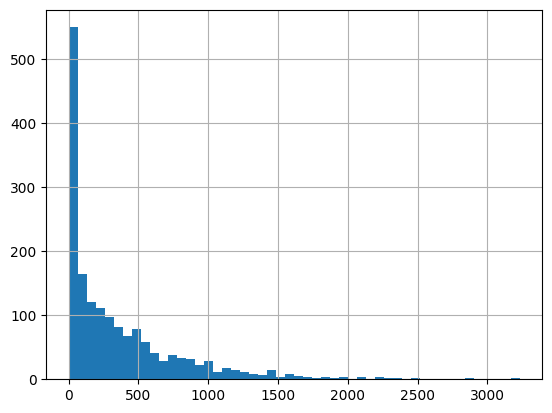

In [70]:
data_counts['Count'].describe()
data_counts['Count'].hist(bins=50)


In [73]:
center_lat = data['lat'].mean()
center_lng = data['lng'].mean()

m = folium.Map(location=[center_lat, center_lng], zoom_start=10, tiles = 'cartodbpositron')

colormap = cm.LinearColormap(colors=['#ffcccc', '#ff6666', "#f10000"], vmin=data_counts['Count'].min(), vmax = data_counts['Count'].max())

for _, row in data_counts.iterrows():
    boundaries = row['Boundaries']
    count = row['Count']
    h3_index = row['H3_Index']
    color = colormap(count)

    folium.Polygon(
        locations=boundaries,
        color=color,
        weight=1,
        fill=True,
        fill_opacity=0.7,
        popup=f'Count: {count}<br>H3 Index: {h3_index}'
    ).add_to(m)

colormap.add_to(m)

m